In [2]:
import RNA
import numpy as np

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

import subprocess
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import SVG, display
from collections import Counter
from collections import defaultdict

import difflib
import sys
import os
import random
import string
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


# from helper import print_moves

import pandas as pd

sys.path.append('../')
from pretty_print_path import print_moves
import findpath_librna
import findpath


In [3]:
input_file = "dataset_105_train.csv"
input_file2 = "dataset_105_vec_train.csv"

dataframe = pd.read_csv(input_file, index_col=0)
# dataframe['target'] = np.where(dataframe["3"]==1, 1, 0)
dataframe = dataframe.drop(labels="s", axis=1)
dataframe = dataframe.drop(labels="i", axis=1)
dataframe = dataframe.drop(labels="j", axis=1)
# dataframe = dataframe.drop(labels="found", axis=1)

# dataframe

vec_dataframe = pd.read_csv(input_file2, index_col=0)
# vec_dataframe
dataframe = pd.concat([dataframe, vec_dataframe], axis=1)


# new
train, _ = train_test_split(dataframe, test_size=0.3)
print(len(train), 'train examples')

# old
# train, test = train_test_split(dataframe, test_size=0.2)
# train, val = train_test_split(train, test_size=0.2)
# print(len(train), 'train examples')
# print(len(val), 'validation examples')
# print(len(test), 'test examples')

# dataframe

3451 train examples


In [4]:
input_file = "dataset_105_test.csv"
input_file2 = "dataset_105_vec_test.csv"

dataframe = pd.read_csv(input_file, index_col=0)
# dataframe['target'] = np.where(dataframe["3"]==1, 1, 0)
dataframe = dataframe.drop(labels="s", axis=1)
dataframe = dataframe.drop(labels="i", axis=1)
dataframe = dataframe.drop(labels="j", axis=1)
# dataframe = dataframe.drop(labels="found", axis=1)

# dataframe

vec_dataframe = pd.read_csv(input_file2, index_col=0)
# vec_dataframe
dataframe = pd.concat([dataframe, vec_dataframe], axis=1)


_, test = train_test_split(dataframe, test_size=0.2)
test, val = train_test_split(train, test_size=0.4)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

3451 train examples
1381 validation examples
2070 test examples


In [5]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# ## Understand the input pipeline
# # Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.

# for feature_batch, label_batch in train_ds.take(1):
#   print('Every feature:', list(feature_batch.keys()))
#   print('A batch of ages:', feature_batch['4'])
#   print('A batch of targets:', label_batch )


2021-11-09 09:37:17.843844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-09 09:37:17.843871: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-09 09:37:17.843886: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (minos.tbi.univie.ac.at): /proc/driver/nvidia/version does not exist
2021-11-09 09:37:17.844305: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  # print(feature_layer(example_batch).numpy())

# # numeric columns
photo_count = feature_column.numeric_column('4')
demo(photo_count)
photo_count2 = feature_column.numeric_column('5')

crossed_feature = feature_column.crossed_column(['4', '1'], hash_bucket_size=10)
demo(feature_column.indicator_column(crossed_feature))

# # column 7 is a catigorical column
# animal_type = feature_column.categorical_column_with_vocabulary_list(
#       '7', [0, 1])
# animal_type_one_hot = feature_column.indicator_column(animal_type)
# demo(animal_type_one_hot)


## Choose which columns to use
We have seen how to use several types of feature columns. Now we will use them to train a model. The goal of this tutorial is to show you the complete code (e.g. mechanics) needed to work with feature columns. We have selected a few columns to train our model below arbitrarily.

Key point: If your aim is to build an accurate model, try a larger dataset of your own, and think carefully about which features are the most meaningful to include, and how they should be represented.

In [219]:
feature_columns = []

# ijd	thisclose	lastclose	cd	en_pos

# numeric cols
for header in ['ijd',	'thisclose',	'lastclose',	'en_pos', 'i_shift',	'j_shift',	'insert_or_delete']:
  feature_columns.append(feature_column.numeric_column(header))

# numeric cols
for header in ['0',	'1',	'2',	'3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']:
  feature_columns.append(feature_column.numeric_column(header))

# categoriacal indicator_columns
indicator_column_names = ['cd']
for col_name in indicator_column_names:
  categorical_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, dataframe[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)

In [7]:
# only use lowest energy as indicator

feature_columns = []

# numeric cols
for header in ['en_pos']:
  feature_columns.append(feature_column.numeric_column(header))

In [8]:
feature_columns

[NumericColumn(key='en_pos', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

### Create a feature layer
Now that we have defined our feature columns, we will use a [DenseFeatures](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/DenseFeatures) layer to input them to our Keras model.

Earlier, we used a small batch size to demonstrate how feature columns worked. We create a new input pipeline with a larger batch size.

In [9]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# batch_size = 32
batch_size = 64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [10]:
epochs = 50

model = tf.keras.Sequential([
  feature_layer,
  # layers.Dense(128, activation='relu'),
  # layers.Dense(128, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=epochs)

Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
22/54 [===========>..................] - ETA: 0s - loss: 0.6300 - accuracy: 0.6584 

2021-11-09 09:37:30.228800: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


44/54 [=======================>......] - ETA: 0s - loss: 0.6202 - accuracy: 0.6442WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'ijd': <tf.Tensor 'ExpandDims_24:0' shape=(None, 1) dtype=float64>, 'thisclose': <tf.Tensor 'ExpandDims_28:0' shape=(None, 1) dtype=float64>, 'lastclose': <tf.Tensor 'ExpandDims_27:0' shape=(None, 1) dtype=float64>, 'cd': <tf.Tensor 'ExpandDims_21:0' shape=(None, 1) dtype=int64>, 'en_pos': <tf.Tensor 'ExpandDims_22:0' shape=(None, 1) dtype=float64>, 'i_shift': <tf.Tensor 'ExpandDims_23:0' shape=(None, 1) dtype=int64>, 'j_shift': <tf.Tensor 'ExpandDims_26:0' shape=(None, 1) dtype=int64>, 'insert_or_delete': <tf.Tensor 'ExpandDims_25:0' shape=(None, 1) dtype=int64>, 'balance': <tf.Tensor 'ExpandDims_20:0' shape=(None, 1) dtype=float64>, '0': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, '1': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, '2': <tf.Tensor 'Ex

In [212]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

16/16 [==============================] - 0s 2ms/step - loss: 0.4664 - accuracy: 0.8602
Accuracy 0.8601823449134827


In [282]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

31/31 [==============================] - 0s 2ms/step - loss: 0.4810 - accuracy: 0.8480
Accuracy 0.848024308681488


In [222]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

31/31 [==============================] - 0s 964us/step - loss: 0.5752 - accuracy: 0.7214
Accuracy 0.7213779091835022


In [ ]:
# 31/31 [==============================] - 0s 1ms/step - loss: 0.6488 - accuracy: 0.7335
# Accuracy 0.7335359454154968

# 31/31 [==============================] - 0s 862us/step - loss: 0.5798 - accuracy: 0.6950
# Accuracy 0.695035457611084

In [13]:
# Save the entire model as a SavedModel.
# !mkdir -p saved_model
# model.save('saved_model/my_model')

# from tensorflow.keras.models import Sequential, save_model, load_model

# filepath = './saved_model'
# save_model(model, filepath)

# Morgan & Higgs: Findpath with SW 1

In [11]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True) # no scientific notation

# import feature_generation
from features import ij_distance, new_move_dist, plt_moves, config_distance, balance_in_all_things, return_shift_moves

from process_features import fp_call, find_moves, process


In [67]:
# input_file = "dataset_100.csv"
# df = pd.read_csv(input_file)

# sequence, s1, s2 = df.loc[0]


# search_width_multiplier = 4
# fp = findpath.findpath_single(sequence, s1, s2, search_width_multiplier=search_width_multiplier, mp=True)
# result = fp.get_en()/100.0
# path = fp.get_path()

# s = s1
# pt2 = list(RNA.ptable(s2))
# fc = RNA.fold_compound(sequence)


# def find_moves(s_ptable, t_ptable):
#     """
#     generator function, yields possible structures 1 move away
#     from the original structure by finding fitting i and j with
#     RNA pair and loop tables
#     s_ptable: current ptable
#     t_ptable: s2 end ptable
#     """
#     # loop table
#     ls = RNA.loopidx_from_ptable(s_ptable)
#     for i in range(len(s_ptable)):
#         if i == 0:
#             continue
#         if s_ptable[i] == 0 and t_ptable[i] > i:
#             j = t_ptable[i]
#             # found j has to be empty and currently on the same loop as i
#             if s_ptable[j] == 0 and ls[i] == ls[j]:
#                 yield i, j
#         # test for bp removal: i has to be paired with a different j in s2
#         j = s_ptable[i]
#         # dont remove things which are present in s2
#         if s_ptable[i] > i and s_ptable[i] != s_ptable[j] and\
#                 s_ptable[i] != t_ptable[i] and s_ptable[j] != t_ptable[j]:
#             yield -i, -j


# def fp_call(sequence, s1, s2, search_width_multiplier = 20):    
#     fp = findpath.findpath_single(sequence, s1, s2, search_width_multiplier=search_width_multiplier, mp=True)
#     result = fp.get_en()/100.0
#     path = fp.get_path()
#     # return result, path
#     return result, path


# def ij_distance(last_move, this_move, ij_moves):
#     # how far is the last move away from the current move.
#     # it is likely, that the next move is close to the last one
#     # there are better distance metrices probably...

#     # ij move list is supposed to be sorted, find indices
    
#     ijmoves = ij_moves + [last_move]
#     ijmoves.sort(key=lambda x: (x[0], x[1]))

#     pos_old = ijmoves.index(last_move)
#     pos_new = ijmoves.index(this_move)

#     distance = abs(pos_old-pos_new)/len(ijmoves)
    
    
#     # moves left in vicinity out of total moves
    
#     thisi, thisj = this_move
#     lasti, lastj = last_move
#     thisclose = 0
#     lastclose = 0

#     for i, j in ij_moves:
#         if (abs(i-thisi) < 5) and (abs(j-thisj) < 5):
#             thisclose += 1
#         if (abs(i-lasti) < 5) and (abs(j-lastj) < 5):
#             lastclose += 1
    

#     thisclose /= len(ij_moves)
#     lastclose /= len(ij_moves)

#     # print ("thisclose", thisclose, lastclose, distance)
#     return distance, thisclose, lastclose

#     print (distance)

# # sample call
# ij_moves = [(3, 62), (4, 61), (6, 60), (7, 59), (9, 57), (10, 56), (11, 55), (12, 54), (15, 52), (16, 51), (17, 50), (18, 39), (19, 38), (20, 36), (21, 35), (22, 34), (23, 33), (24, 32), (42, 49), (43, 48), (64, 99)]
# last_move = (2, 63)
# this_move = (6, 60)
# ij_distance(last_move, this_move, ij_moves)

# # 

# def config_distance(pt, move):
#     """
#     are we extending / removing the outside/inside layer of a loop or adding something in the middle?
#     """
#     i = move[0]
#     j = move[1]
#     points = 0

#     # if we're extending from outside to inside, the position i+1 and j-1 should be ideally unpaired
#     # inside to outside: i-1 and j+1 should be ideally unpaired

#     if i>0:
#         # print ("add") 
#         # outside/inside paired?        
#         if j+1 < pt[0] and i-1 > 0: # outside - boundary check
#             if pt[i-1] == j+1:
#                 points += 1
#         if pt[i+1] == j-1:
#             points += 1
#     if i<0:
#         # print ("del")
#         i, j = -i, -j
#         # outside/inside paired?
#         if j+1 < pt[0] and i-1 > 0: # outside - boundary check
#             if pt[i-1] == j+1:
#                 points += 1
#         if pt[i+1] == j-1:
#             points += 1
#         elif pt[i+1] == 0 and pt[j-1] == 0:
#             pass

#     if points == 2:
#         points = 0
#     return points


# s = s1
# lasts = s
# lasti = None
# lastj = None

# for e, (a,b, en) in enumerate(path):
#     if (a,b) == (0,0):
#         continue  

#     # check where we can go, compare with our best move. 
#     pt = list(RNA.ptable(s))

#     # check available moves, save them, sort them    
#     avail_moves = []
#     ij_moves = []
#     found_pos = None

#     for pos, (i,j) in enumerate(find_moves(pt, pt2)):    
#         next_en = fc.eval_move_pt(pt, i, j)
#         # mark where we found our move
#         found = (i,j) == (a,b)
#         avail_moves.append((i, j, next_en, found))
#         ij_moves.append((abs(i),abs(j)))

#     # sort moves independent of delete insert moves

#     ij_moves.sort(key=lambda x: (x[0], x[1]))


#     avail_moves.sort(key=lambda x: x[2])
#     found_list = [x[3] for x in avail_moves]
#     en_list = np.array([[x[2] for x in avail_moves]])
#     en_list_scaled = min_max_scaler.fit_transform(en_list.T).T[0]
    

#     # find where our move is after sorting
#     found_pos = found_list.index(True)
#     rel_pos = found_pos * 1.0 / len(found_list)

#     # print (e, a,b, 'found at pos:', found_pos, 'of', len(avail_moves), ':',  1-rel_pos)
#     # print (avail_moves, a, b)

#     # if s != lasts:
#         # print ("---") 
#         # print (s)
#         # print ("---") 

#     # for every move we take we have to run a new findpath, see if this move will yield the ideal result
    
#     for pos, (i,j, en, found) in enumerate(avail_moves):
#         if i > 0:
#             snew = s[:i-1] + "(" + s[i:j-1] + ")" + s[j:]
#         if i < 0:
#             snew = s[:-i-1] + "." + s[-i:-j-1] + "." + s[-j:]
#         ptnew = list(RNA.ptable(snew))

#         result_new, path = fp_call(sequence, snew, s2)

#         if result_new <= result:
#             pos_result = 1
#         else:
#             pos_result = 0

#         if found: found = "<-- taken"
#         else: found = ""

#         this_move = (abs(i), abs(j))
#         last_move = (lasti, lastj)

#         if lasti:
#             # print (this_move, last_move, ij_moves)
#             ijd, thisclose, lastclose = ij_distance(last_move, this_move, ij_moves)
#         else:
#             ijd, thisclose, lastclose = 0, 0, 0

#         cd = config_distance(pt, this_move)

#         if lasti:
#             print (f' {snew[0:20]}, {i}, {j}, {result_new}/{pos_result}: {ijd:2.2f}, {thisclose:2.2f}, {lastclose:2.2f}, {cd}, {en}, {en_list_scaled[pos]:2.2f} {found}')

#             sample = 1, ijd, thisclose, lastclose, cd, en_list_scaled[pos], 1
#             sample_test_ds = sample_to_dataset(sample, test)
#             result_predictor = model.predict(sample_test_ds)[0][0]

#             print (f' {1}, {ijd:2.2f}, {thisclose:2.2f}, {lastclose:2.2f}, {cd}, {en_list_scaled[pos]:2.2f}, 1: prediction: {result_predictor}')



#     # if e==63:
#     #     print (avail_moves)

#     # update s for the next iteration
    
#     lasts = s
#     lasti = abs(a)
#     lastj = abs(b)
#     if a > 0:
#         s = s[:a-1] + "(" + s[a:b-1] + ")" + s[b:]
#     if a < 0:
#         s = s[:-a-1] + "." + s[-a:-b-1] + "." + s[-b:]

#     if e>1: 
#         break



In [224]:
# A few random samples

# Generate predictions for samples
predictions = model.predict(test_ds)
predictions
# sample_test
# test_ds

array([[-15.837],
       [ 11.275],
       [  3.746],
       ...,
       [ 24.054],
       [ -6.914],
       [ -3.432]], dtype=float32)

In [13]:
# A utility method to create a tf.data from a dictionary
def dict_to_dataset(inputdict, labels, shuffle=True, batch_size=32):
  # dataframe = dataframe.copy()
  # labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((inputdict, labels))
  # ds = tf.data.Dataset.from_tensor_slices([45240,  0.5,  0.142857,  0.047619,  0,  0.930233,       0])
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))  
  print ('ds', ds)
  ds = ds.batch(batch_size)
  return ds

def sample_to_dataset(sample, test):

  sample_test = test.iloc[0:1].copy()
  row0 = sample_test.index[0]

  # print (sample_test)

  for key, value in sample.items():
    sample_test.at[row0, key] = value
# 
  # print (sample_test)

  # print (i, j)
  # sample_test.at[row0 ,'Unnamed: 0'] = 2 # irrelevant
  # sample_test.at[row0 ,'4'] = sample[1]
  # sample_test.at[row0 ,'5'] = sample[2]
  # sample_test.at[row0 ,'6'] = sample[3]
  # sample_test.at[row0 ,'7'] = sample[4]
  # sample_test.at[row0 ,'8'] = sample[5]
  # sample_test.at[row0 ,'target'] = 2 # irrelevant

  sample_test_ds = df_to_dataset(sample_test, shuffle=False, batch_size=batch_size)
  return sample_test_ds


sample = { "target": 0,
           "ijd":    1,
           "thisclose": 0.2,
           "lastclose": 0.5,
           "cd":        0.5,
           "en_pos":    0.7,
           "i_shift":   1, 
           "j_shift":   1,
           "insert_or_delete": 0,
           "balance":   1,
           "19": 0.5
}

# sample = [1, 0.82, 0.44, 0.24, 1, 0.05, 1]
# sample = 1, 0.36, 0.29, 0.14, 1, 0.00, 1
sample_test_ds = sample_to_dataset(sample, test)

# print (sample_test_ds)

result_predictor = model.predict(sample_test_ds)[0][0]
print (result_predictor)


predictions = model.predict(sample_test_ds)
predictions

-32.443512


array([[-32.443512]], dtype=float32)

In [269]:
filename_samples = f'./dataset_100.csv'
samples_df = pd.read_csv(filename_samples)

sequence = ''
s1 = ''
s2 = ''

for index, row in samples_df.iterrows():
    if index != 22:
        continue
    sequence = row.sequence
    s1 = row.s1
    s2 = row.s2

print (sequence)
print (s1)
print (s2)

fc = RNA.fold_compound(sequence)
en1 = fc.eval_structure(s1)
en2 = fc.eval_structure(s2)

def fp_call_sw(sequence, s1, s2, search_width):    
    fp = findpath.findpath_single(sequence, s1, s2, search_width=search_width, mp=True)
    result = fp.get_en()/100.0
    path = fp.get_path()
    # return result, path
    return result, path


sw = 1
sw = 100

r, p = fp_call_sw(sequence, s1, s2, sw)
p = [(i[0], i[1]) for i in p]

print_moves(sequence, s1, s2, p)


ACGGUAUCGGGGCCCUCCAACCACCAAGCGGCAGGAUUGCCACGCUACGGUUGAUGGCGUUUAGUAGUUGAUACGUCAAGACGUCGAAACGCUCAGUAGC
........((.(((.((.((((....(((((((....))))..)))..)))))).))).)).(((.(((...((((....))))...)))))).......
..(((.....((........)))))..(.((((....)))).)(((((...((.((((((((....((....))....))))))))...))....)))))
ACGGUAUCGGGGCCCUCCAACCACCAAGCGGCAGGAUUGCCACGCUACGGUUGAUGGCGUUUAGUAGUUGAUACGUCAAGACGUCGAAACGCUCAGUAGC
........((.(((.((.((((....(((((((....))))..)))..)))))).))).)).(((.(((...((((....))))...))))))....... [   0,    0 ] -21.40
.........(.(((.((.((((....(((((((....))))..)))..)))))).))).)..(((.(((...((((....))))...))))))....... [  -9,  -61 ] -21.00
...........(((.((.((((....(((((((....))))..)))..)))))).)))....(((.(((...((((....))))...))))))....... [ -10,  -60 ] -21.00
...........(((.((.((((....(((((((....))))..)))..)))))).))).....((.(((...((((....))))...)))))........ [ -63,  -93 ] -19.90
...........(((.((.((((....(((((((....))))..)))..)))))).))).....(..(((...((((....))))...))).)........ [ -65, 

-10.0

In [259]:
# s = s1
# fc = RNA.fold_compound(sequence)
# pt = list(RNA.ptable(s))
# pt2 = list(RNA.ptable(s2))

# lasts = s
# lasti = 0
# lastj = 0
# last_move = (0,0)

# en_max = fc.eval_structure(s)


# result, path = fp_call(sequence, s1, s2, 1)
# all_moves = [(abs(i[0]), abs(i[1])) for i in path]

# prev_move_dist = np.zeros((20)) 

# found_moves = [(0, 0)]

# dist = 0

# while True:

#     dist += 1
#     # check where we can go, compare with our best move. 
#     pt = list(RNA.ptable(s))

#     # check available moves, save them, sort them    
#     avail_moves = []
#     ij_moves = []
#     found_pos = None

    # # collect moves from the generator function, then sort them.
    # for pos, (i,j) in enumerate(find_moves(pt, pt2)):    
    #     next_en = fc.eval_move_pt(pt, i, j)
    #     # mark where we found our move
    #     found = None
    #     avail_moves.append((i, j, next_en, found))
    #     ij_moves.append((abs(i),abs(j)))


    # avail_moves.sort(key=lambda x: x[2])
    # found_list = [x[3] for x in avail_moves]
    # en_list = np.array([[x[2] for x in avail_moves]])
    # en_list_scaled = min_max_scaler.fit_transform(en_list.T).T[0]

    # i_shift_moves, j_shift_moves = return_shift_moves(all_moves)

    # # print (s, pt, avail_moves)
    # # print (en_list_scaled)

    # candidates = []

    # for pos, (i,j, en, found) in enumerate(avail_moves):

    #     this_move = (abs(i), abs(j))
    #     last_move = (lasti, lastj)

    #     if lasti:
    #         # print (this_move, last_move, ij_moves)
    #         ijd, thisclose, lastclose = ij_distance(last_move, this_move, ij_moves)
    #     else:
    #         ijd, thisclose, lastclose = 0, 0, 0

#         cd = config_distance(pt, this_move)

#         en_scaled = en_list_scaled[pos]


#         if abs(i) in i_shift_moves:
#             i_shift = 1
#         else:
#             i_shift = 0
#         if abs(j) in j_shift_moves:
#             j_shift = 1
#         else:
#             j_shift = 0

#         if i<0:
#             insert_or_delete = 0
#         else:
#             insert_or_delete = 1

#         if i > 0:
#             snew = s[:i-1] + "(" + s[i:j-1] + ")" + s[j:]
#         if i < 0:
#             snew = s[:-i-1] + "." + s[-i:-j-1] + "." + s[-j:]
#         # ptnew = list(RNA.ptable(snew))
#         balance = balance_in_all_things(s1, s2, snew) / len(all_moves)


#         # run the prediction
#         sample = 1, ijd, thisclose, lastclose, cd, en_list_scaled[pos], 1
        
#         sample = { "target": 0,
#            "ijd":       ijd,
#            "thisclose": thisclose,
#            "lastclose": lastclose,
#            "cd":        cd,
#            "en_pos":    en_list_scaled[pos],
#            "i_shift":   i_shift, 
#            "j_shift":   j_shift,
#            "insert_or_delete": insert_or_delete,
#            "balance":   balance,
#             "0":  prev_move_dist[0],
#             "1":  prev_move_dist[1],
#             "2":  prev_move_dist[2],
#             "3":  prev_move_dist[3],
#             "4":  prev_move_dist[4],
#             "5":  prev_move_dist[5],
#             "6":  prev_move_dist[6],
#             "7":  prev_move_dist[7],
#             "8":  prev_move_dist[8],
#             "9":  prev_move_dist[9],
#             "10":  prev_move_dist[10],
#             "11":  prev_move_dist[11],
#             "12":  prev_move_dist[12],
#             "13":  prev_move_dist[13],
#             "14":  prev_move_dist[14],
#             "15":  prev_move_dist[15],
#             "16":  prev_move_dist[16],
#             "17":  prev_move_dist[17],
#             "18":  prev_move_dist[18],
#             "19":  prev_move_dist[19],
#         }       
        
#         sample_test_ds = sample_to_dataset(sample, test)
#         result_predictor = model.predict(sample_test_ds)[0][0]

#         candidates.append((i, j, en_scaled, result_predictor, en))
        
#         # print (ijd, thisclose, lastclose, cd, en_scaled, result_predictor)


#     # print (prev_move_dist)

#     candidates.sort(key=lambda x: -x[3])
#     # candidates.sort(key=lambda x: x[2])



#     # print (candidates)

#     # chosen move
#     i = candidates[0][0]
#     j = candidates[0][1]

#     lasts = s
#     lasti = abs(i)
#     lastj = abs(j)

#     prev_move_dist = new_move_dist(lasti, lastj, prev_move_dist)

#     if i > 0:
#         s = s[:i-1] + "(" + s[i:j-1] + ")" + s[j:]
#     if i < 0:
#         s = s[:-i-1] + "." + s[-i:-j-1] + "." + s[-j:]

#     en_new = fc.eval_structure(s)
#     if en_new > en_max:
#         en_max = en_new

#     # print (s, i, j, en_new, en_max)

#     found_moves.append((i, j))

#     for i0, (i1, i2, i3, i4, i5) in enumerate(candidates):
#         print (f' {dist:3}, {en_max:2.2}, {i0:6}, {i1:6}, {i2:6}, {i3:6.2}, {i4:6.4}, {i5:6}')
#         if i0 == 3:
#             break

#     # break

#     if s==s2:
#         break


# # WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'ijd': <tf.Tensor 'ExpandDims_24:0' shape=(None, 1) dtype=float64>, 'thisclose': <tf.Tensor 'ExpandDims_28:0' shape=(None, 1) dtype=float64>, 'lastclose': <tf.Tensor 'ExpandDims_27:0' shape=(None, 1) dtype=float64>, 'cd': <tf.Tensor 'ExpandDims_21:0' shape=(None, 1) dtype=int64>, 'en_pos': <tf.Tensor 'ExpandDims_22:0' shape=(None, 1) dtype=float64>, 'i_shift': <tf.Tensor 'ExpandDims_23:0' shape=(None, 1) dtype=int64>, 'j_shift': <tf.Tensor 'ExpandDims_26:0' shape=(None, 1) dtype=int64>, 'insert_or_delete': <tf.Tensor 'ExpandDims_25:0' shape=(None, 1) dtype=int64>, 'balance': <tf.Tensor 'ExpandDims_20:0' shape=(None, 1) dtype=float64>, '0': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, '1': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, '2': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=float64>, '3': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=float64>, '4': <tf.Tensor 'ExpandDims_14:0' shape=(None, 1) dtype=float64>, '5': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=float64>, '6': <tf.Tensor 'ExpandDims_16:0' shape=(None, 1) dtype=float64>, '7': <tf.Tensor 'ExpandDims_17:0' shape=(None, 1) dtype=float64>, '8': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dtype=float64>, '9': <tf.Tensor 'ExpandDims_19:0' shape=(None, 1) dtype=float64>, '10': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, '11': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, '12': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, '13': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=float64>, '14': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, '15': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float64>, '16': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, '17': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=float64>, '18': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=float64>, '19': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) dtype=float64>}
# Consider rewriting this model with the Functional API.

In [18]:
print_moves(sequence, s1, s2, found_moves)

GCUUUGGAUUUCCGGGCCAUUAACGCACCCCGUCUAGUAUCCCACUAUGGCAAGCUAACUUAAAGGUCUAGAAAGCCGAACCAGCUCCCGUCUAGACCGU
((((.((....))(((............)))(((((((.....)))).))))))).........((((((((....(......)......)))))))).. [   0,    0 ] -19.30
((((.((....))(((............)))(((((((.....)))).))))))).........((((((((..................)))))))).. [ -77,  -84 ] -19.20
((((.((....))(((............)))(((((((.....)))).))))))).........((((((((...(.......)......)))))))).. [  76,   84 ] -16.90
((((.((....))(((............)))(((((((.....)))).))))))).........((((((((..((.......)).....)))))))).. [  75,   85 ] -20.60
((((.((....))(((............)))(((((((.....)))).))))))).........((((((((.(((.......)))....)))))))).. [  74,   86 ] -21.30
((((.((....))(((............)))(.(((((.....)))).).))))).........((((((((.(((.......)))....)))))))).. [ -33,  -50 ] -16.80
((((.((....))(((............)))..(((((.....)))).)..)))).........((((((((.(((.......)))....)))))))).. [ -32,  -51 ] -17.30
((((.((....))(((............)))...((((.....))

-11.0

In [14]:
# todo: optimal path, compare with greedy & ML choice

# check positions: at which position did we find the best move in our move set? 


# function needs: sequence, s1, s2, lasts, currents

def next_moves(sequence, s1, s2, lastmove, s, prev_move_dist = np.zeros((20))):

    # first do a basic findpath call with minimal search width to get all moves (simple, but expensive)

    search_width_multiplier = 20
    result, path = fp_call(sequence, s1, s2, search_width_multiplier)
  

    all_moves = [(abs(i[0]), abs(i[1])) for i in path]
    i_shift_moves, j_shift_moves = return_shift_moves(all_moves)
      

    prev_move_dist = new_move_dist(lastmove[0], lastmove[1], prev_move_dist)

    # print (all_moves, i_shift_moves, prev_move_dist)
    
    fc = RNA.fold_compound(sequence)
    pt = list(RNA.ptable(s))
    pt2 = list(RNA.ptable(s2))

    # check available moves based on our current structure
    avail_moves = []
    ij_moves = []
    found_pos = None

    for pos, (i,j) in enumerate(find_moves(pt, pt2)):    
        next_en = fc.eval_move_pt(pt, i, j)
        # mark where we found our move
        avail_moves.append((i, j, next_en))
        ij_moves.append((abs(i),abs(j)))

    # sort moves independent of delete insert moves
    ij_moves.sort(key=lambda x: (x[0], x[1]))

    avail_moves.sort(key=lambda x: x[2])

    # sort avail moves by energy
    en_list = np.array([[x[2] for x in avail_moves]])
    en_list_scaled = min_max_scaler.fit_transform(en_list.T).T[0] # best en gets 0, worst = 1

    for pos, (i,j, en) in enumerate(avail_moves):           

        en_scaled = en_list_scaled[pos]

        if i > 0:
            snew = s[:i-1] + "(" + s[i:j-1] + ")" + s[j:]
        if i < 0:
            snew = s[:-i-1] + "." + s[-i:-j-1] + "." + s[-j:]
        ptnew = list(RNA.ptable(snew))
        

        thismove = (abs(i), abs(j))

        # generate features
        if lastmove != (0,0):
            # print (this_move, last_move, ij_moves)
            ijd, thisclose, lastclose = ij_distance(lastmove, thismove, ij_moves)
        else:
            ijd, thisclose, lastclose = 0, 0, 0
        cd = config_distance(pt, thismove)            
        if abs(i) in i_shift_moves:
            i_shift = 1
        else:
            i_shift = 0
        if abs(j) in j_shift_moves:
            j_shift = 1
        else:
            j_shift = 0
        if i<0:
            insert_or_delete = 0
        else:
            insert_or_delete = 1
        balance = balance_in_all_things(s1, s2, snew) / len(all_moves)

        # compare our prediction with true labels: compute findpath with all next s:        

        result_new, path = fp_call(sequence, snew, s2, search_width_multiplier)   
        en_current = fc.eval_structure(s)
        en_max = max(result_new, en_current)

        # if our energy is lower or equal to the overall findpath call, then this i,j move gets the true label 1. 
        if en_max <= result:
            en_max = 1
        else:
            en_max = 0

        en_max = result_new

        # print ('overall fp:', result, 'fp result from snew', result_new, 'en max', max(result_new, en_current), en_max)

        # result_new = 
        




        return_vals = [snew, i, j, en_max, ijd, thisclose, lastclose, cd, en_scaled, i_shift, j_shift, insert_or_delete, balance] + list(prev_move_dist)

        yield return_vals
        # print (i, j, en_scaled, result_new, balance, insert_or_delete, cd)

    # print (avail_moves, en_list_scaled)
    # print (prev_move_dist)
    


# sequence = "GCUUUGGAUUUCCGGGCCAUUAACGCACCCCGUCUAGUAUCCCACUAUGGCAAGCUAACUUAAAGGUCUAGAAAGCCGAACCAGCUCCCGUCUAGACCGU"
# s1       = "((((.((....))(((............)))(((((((.....)))).))))))).........((((((((....(......)......)))))))).."
# s2       = "...((((.(((....((((...(((.....))).((((.....)))))))))))))))......((((((((.(((.......)))....)))))))).."
# lastmove = [  25,   31 ]
# s        = "((((.((....)).........(((.....))).((((.....))))....)))).........((((((((.(((.......)))....)))))))).."

sequence = "ACGGUAUCGGGGCCCUCCAACCACCAAGCGGCAGGAUUGCCACGCUACGGUUGAUGGCGUUUAGUAGUUGAUACGUCAAGACGUCGAAACGCUCAGUAGC"
s1       = "........((.(((.((.((((....(((((((....))))..)))..)))))).))).)).(((.(((...((((....))))...))))))......."
s2       = "..(((.....((........)))))..(.((((....)))).)(((((...((.((((((((....((....))....))))))))...))....)))))"
s = s1
lastmove = (0,0)

def predict_next_moves(sequence, s1, s2, lastmove, s, prev_move_dist):
    results = []
    for vals in next_moves(sequence, s1, s2, lastmove, s, prev_move_dist):
        results.append(vals)

    output_df = pd.DataFrame(results)
    output_df.columns = ['s', 'i', 'j', 'target', 'ijd', 'thisclose', 'lastclose', 'cd', 'en_pos',\
                        'i_shift', 'j_shift', 'insert_or_delete', 'balance',\
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',\
                        '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']

    # def sample1_to_dataset(test):
    #   sample_test = test.iloc[0:5].copy()
    #   sample_test_ds = df_to_dataset(sample_test, shuffle=False, batch_size=batch_size)
    #   return sample_test_ds
    # batch_prediction = sample1_to_dataset(test)
    # print (batch_prediction)

    batch_prediction = df_to_dataset(output_df, shuffle=False, batch_size=batch_size)
    result_predictor = model.predict(batch_prediction)

    output_df["prediction"] = result_predictor

    return output_df


prev_move_dist = np.zeros((20))
pred_df = predict_next_moves(sequence, s1, s2, lastmove, s, prev_move_dist)
# pred_df


### Move along a good path, compare results with our predictor

In [15]:

# sequence = "GCUUUGGAUUUCCGGGCCAUUAACGCACCCCGUCUAGUAUCCCACUAUGGCAAGCUAACUUAAAGGUCUAGAAAGCCGAACCAGCUCCCGUCUAGACCGU"
# s1       = "((((.((....))(((............)))(((((((.....)))).))))))).........((((((((....(......)......)))))))).."
# s2       = "...((((.(((....((((...(((.....))).((((.....)))))))))))))))......((((((((.(((.......)))....)))))))).."

# sequence = "ACCGAUUGACUAAGUAUAGUUCCUUCACCGUUAUUCUGAUCGCCGGAGAGUUUUACGCGUCAUUUCCCGCUCAAACCCGCUCAUUGCUGAACGUUGAAGA"
# s1       = ".......(((((....))))).(((((.((((.........((.(((((.............))))).))........((.....))..)))).)))))."
# s2       = ".......(((((....))))).(((((.(((........(((.(((.(((((((..(((........)))..)))...)))).))).)))))).)))))."


search_width_multiplier = 20
result, path = fp_call(sequence, s1, s2, search_width_multiplier)
# print_moves(sequence, s1, s2, path)

s = s1
lasts = s1
lastmove = (0,0)
prev_move_dist = np.zeros((20))

compare_list = []

for e, (i, j, _) in enumerate(path):

    if e==0: continue

    # print (s, i, j)
    # print (prev_move_dist)

    predict_df = predict_next_moves(sequence, s1, s2, lastmove, s, prev_move_dist)

    # print (predict_df)

    # if e==3:
    #     print ("move", i, j)
    #     print (predict_df)

    # if i==41:
    #     print (predict_df)

    # if we want to sort with our predictor
    predict_df.sort_values(by=['prediction'], ascending=False, ignore_index=True, inplace=True)

    choices = predict_df.shape[0]
    pred_row = predict_df[predict_df['i'] == i]

    # we have to verify here which moves actually lead to the optimal result! 
    # alternatively: find the first row with target==1:
    # we don't exactly have to hit the same i,j but a move which leads to the same optimal result


    # print (predict_df[['i', 'j', 'target', 'en_pos', 'prediction']].head())


    # compare = predict_df[predict_df['target'] == 1].index.values[0]
    best_en = predict_df['target'].min()
    compare = predict_df[predict_df['target'] == best_en].index.values[0]

    compare_list.append(compare/choices)

    # print (predict_df[predict_df['target'] == 1])

    # print (pred_row)
    print ('Chosen i', i, 'j', j, 'choice:', pred_row.index.values[0], 'out of', choices, 'or', compare, 'out of', choices)


    # update s with our predefined move
    lasts = s
    lastmove = (abs(i), abs(j))

    prev_move_dist = new_move_dist(lastmove[0], lastmove[1], prev_move_dist)

    if i > 0:
        s = s[:i-1] + "(" + s[i:j-1] + ")" + s[j:]
    if j < 0:
        s = s[:-i-1] + "." + s[-i:-j-1] + "." + s[-j:]



    # break

    # if e>=10: 
    #     break

    # if e==3: 
    #     break

    # if e==5:        
    #     print (predict_df)
    #     break



Chosen i -9 j -61 choice: 0 out of 24 or 0 out of 24
Consider rewriting this model with the Functional API.
Chosen i -10 j -60 choice: 0 out of 23 or 0 out of 23
Chosen i -76 j -81 choice: 1 out of 22 or 0 out of 22
Chosen i -63 j -93 choice: 0 out of 21 or 0 out of 21
Chosen i -74 j -83 choice: 16 out of 20 or 0 out of 20
Chosen i -65 j -91 choice: 2 out of 19 or 0 out of 19
Chosen i -75 j -82 choice: 2 out of 18 or 0 out of 18
Chosen i -73 j -84 choice: 0 out of 17 or 0 out of 17
Chosen i -64 j -92 choice: 0 out of 16 or 0 out of 16
Chosen i -69 j -88 choice: 3 out of 15 or 3 out of 15
Chosen i -68 j -89 choice: 0 out of 14 or 0 out of 14
Chosen i -67 j -90 choice: 0 out of 14 or 0 out of 14
Chosen i -19 j -52 choice: 1 out of 18 or 1 out of 18
Chosen i 67 j 74 choice: 4 out of 17 or 4 out of 17
Chosen i 68 j 73 choice: 0 out of 16 or 0 out of 16
Chosen i 59 j 82 choice: 2 out of 15 or 2 out of 15
Chosen i 60 j 81 choice: 0 out of 14 or 0 out of 14
Chosen i 61 j 80 choice: 0 out of 1

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.05555555555555555, 0.23529411764705882, 0.0, 0.13333333333333333, 0.0, 0.0, 0.0, 0.6363636363636364, 0.0, 0.3, 0.0, 0.0, 0.0, 0.1111111111111111, 0.0, 0.1111111111111111, 0.25, 0.0, 0.3076923076923077, 0.0, 0.09090909090909091, 0.0, 0.0, 0.125, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/home/mescalin/maxf/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


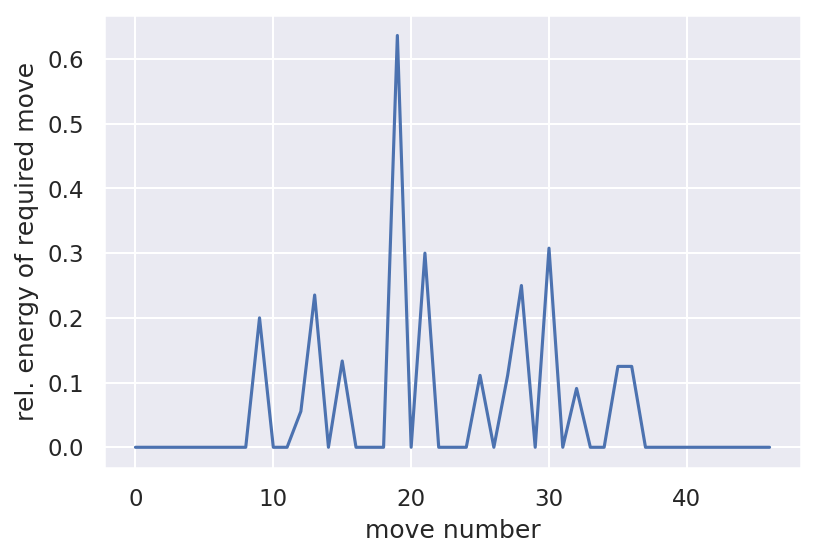

In [26]:

print (compare_list)
# search_width_multiplier = 20
# result, path = fp_call(sequence, s1, s2, search_width_multiplier)
# print_moves(sequence, s1, s2, path)

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 150

sns.set_theme(style="darkgrid")

y = compare_list
x = list(range(len(y)))
# x = ['day 1', 'day 2', 'day 3']

sns.lineplot(x, y)

plt.xlabel("move number")
plt.ylabel("rel. energy of required move")
plt.show()


In [27]:
# i -42 j -70 choice: 2 out of 11
# i -43 j -69 choice: 0 out of 11
# i -49 j -63 choice: 1 out of 10
# i -48 j -64 choice: 0 out of 9
# i -47 j -65 choice: 1 out of 8
# i -45 j -67 choice: 1 out of 7
# i -46 j -66 choice: 0 out of 6
# i 58 j 69 choice: 1 out of 11
# i 57 j 70 choice: 0 out of 10
# i 59 j 68 choice: 0 out of 9
# i -32 j -90 choice: 0 out of 8
# i 41 j 89 choice: 5 out of 8
# i 40 j 90 choice: 0 out of 7
# i -79 j -87 choice: 3 out of 6
# i -80 j -86 choice: 0 out of 6
# i 42 j 88 choice: 0 out of 11
# i 44 j 86 choice: 0 out of 10
# i 45 j 85 choice: 0 out of 9
# i 46 j 84 choice: 0 out of 8
# i 49 j 81 choice: 3 out of 7
# i 50 j 80 choice: 1 out of 6
# i 53 j 74 choice: 3 out of 5
# i 54 j 73 choice: 2 out of 4
# i 52 j 75 choice: 2 out of 3
# i 51 j 79 choice: 1 out of 2
# i 48 j 82 choice: 0 out of 1

# print (predict_df)